In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
home_dir = op.abspath('./')

#plotting settings
fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
sns.__version__

'0.13.2'

In [3]:
region_df = pd.read_csv('./csvs/region_comparison.csv')
spike_thresh = 5
mask_map = {'caudate':'Caudate',
           'putamen':'Putamen',
           'nacc':'NAcc',
           'OT':'OTC',
            'striatum':'Striatum',
           'S1':'S1'}
region_df['mask'] = [mask_map[x] for x in region_df['mask']]
region_df[''] = region_df['group']
region_df = region_df[region_df['spikes'] <=spike_thresh]
len(set(region_df['sub']))

79

In [4]:
###load null distributions
null_prefs = np.loadtxt('./csvs/null_prefs.csv')
null = np.loadtxt('./csvs/null_distribution.csv')
loc_df = pd.read_csv('./csvs/loc_df.csv')

scores = np.loadtxt('./csvs/loo_scores.csv')

scores = pd.DataFrame({'scores':scores})

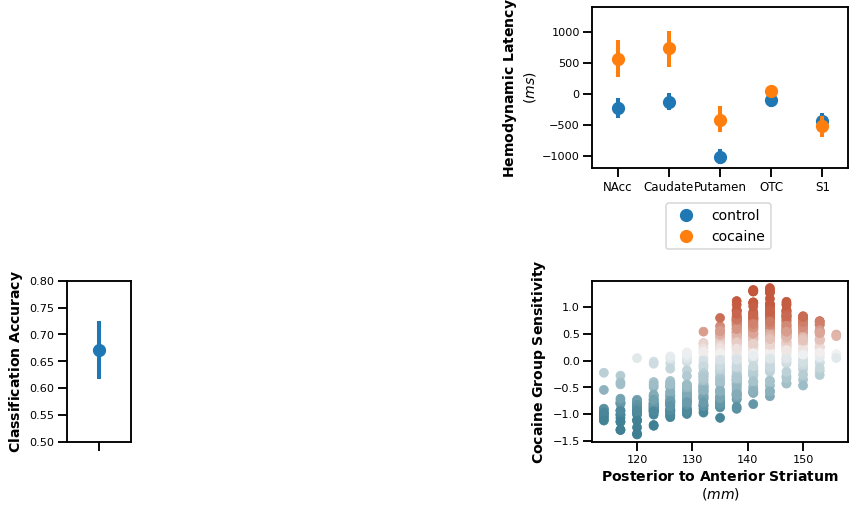

In [5]:
fig,ax=plt.subplots(2,3,
                    figsize=(14,8),
                    width_ratios=[.3,1, 1.2],
                    sharex=False,
                    sharey=False)

for i in range(2):
    for j in range(3):
        ax[i][j].tick_params(labelsize=ticksize)
        ax[i][j].xaxis.get_label().set_fontsize(fontsize)
        ax[i][j].yaxis.get_label().set_fontsize(fontsize)

##################
####Top Right######
##################
sns.pointplot(x = 'mask',
             y = 'lag',
             errorbar=('ci', 68),
              order = ['NAcc','Caudate','Putamen','OTC','S1'],
              hue = '',
              hue_order = ['control','cocaine'],
             linestyle='none',
              ax = ax[0,2],
             data = region_df)
ax[0,2].set_ylim([-1200, 1400])
ax[0][2].set(xlabel = '',
            ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$')
ax[0][2].tick_params(axis = 'x',
                    labelsize=fontsize*.85)
sns.move_legend(ax[0][2], "upper right",bbox_to_anchor=(.725,-.175))


##################
####Bottom Left####
##################

sns.pointplot(y = 'scores',
              errorbar=('ci', 68),
              ax = ax[1,0],
              data = scores)
ax[1,0].set_ylim([.5, .8])
ax[1][0].set(xlabel = '',
            ylabel = '$\\bf{Classification\ Accuracy}$')


##################
####Bottom Right####
##################
sns.scatterplot(x = 'y',
          y = 'prefs',
           hue = 'prefs',
           palette = sns.diverging_palette(220, 20, n = len(set(loc_df['prefs']))),
           legend = False,
                edgecolors = None,
                ax = ax[1,2],
          data = loc_df)
ax[1][2].set(xlabel = '$\\bf{Posterior\ to\ Anterior\ Striatum}$\n$\it{(mm)}$',
            ylabel = '$\\bf{Cocaine\ Group\ Sensitivity}$')


##################
####Misc##########
##################
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,1].axis('off')



plt.subplots_adjust(hspace = .7,
                   wspace= .7)
# plt.savefig('../figs/paper/fig4_figs.png',
#                             bbox_inches = 'tight',
#             dpi = 300)

In [6]:
sub_df = region_df[region_df['mask'].isin(['OTC','NAcc','Putamen','Caudate','S1'])]
md = smf.mixedlm("lag ~ C(group, Treatment('control'))*C(mask,Treatment('NAcc'))", sub_df, 
                 groups=sub_df["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Mixed Linear Model Regression Results
===================================================================================================================================
Model:                                      MixedLM                         Dependent Variable:                         lag        
No. Observations:                           395                             Method:                                     REML       
No. Groups:                                 79                              Scale:                                      708994.0887
Min. group size:                            5                               Log-Likelihood:                             -3203.7276 
Max. group size:                            5                               Converged:                                  Yes        
Mean group size:                            5.0                                                                                    
-----------------------------------------------------------------------------------------------------------------------------------
                                                                                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         -229.988  162.731 -1.413 0.158  -548.935   88.959
C(group, Treatment('control'))[T.cocaine]                                          789.031  228.694  3.450 0.001   340.799 1237.262
C(mask, Treatment('NAcc'))[T.Caudate]                                              103.043  190.679  0.540 0.589  -270.682  476.768
C(mask, Treatment('NAcc'))[T.OTC]                                                  127.432  190.679  0.668 0.504  -246.293  501.157
C(mask, Treatment('NAcc'))[T.Putamen]                                             -788.506  190.679 -4.135 0.000 -1162.231 -414.781
C(mask, Treatment('NAcc'))[T.S1]                                                  -216.584  190.679 -1.136 0.256  -590.309  157.141
C(group, Treatment('control'))[T.cocaine]:C(mask, Treatment('NAcc'))[T.Caudate]     72.195  267.971  0.269 0.788  -453.019  597.408
C(group, Treatment('control'))[T.cocaine]:C(mask, Treatment('NAcc'))[T.OTC]       -651.573  267.971 -2.432 0.015 -1176.787 -126.360
C(group, Treatment('control'))[T.cocaine]:C(mask, Treatment('NAcc'))[T.Putamen]   -192.349  267.971 -0.718 0.473  -717.562  332.865
C(group, Treatment('control'))[T.cocaine]:C(mask, Treatment('NAcc'))[T.S1]        -870.899  267.971 -3.250 0.001 -1396.113 -345.686
Group Var                                                                       323781.838   99.628                                
===================================================================================================================================

"""

In [7]:
spike_df = region_df[['sub','lag','group','mask','spikes','fwd']].groupby(['sub','group','mask']).mean().reset_index()
spike_df = spike_df[spike_df['mask'] == 'NAcc']

md = smf.ols("spikes ~ C(group, Treatment('control'))",
             spike_df).fit()
print(md.summary())

md = smf.ols("fwd ~ C(group, Treatment('control'))",
             spike_df).fit()
print(md.summary())


                            OLS Regression Results                            
Dep. Variable:                 spikes   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2007
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.655
Time:                        12:05:01   Log-Likelihood:                -133.54
No. Observations:                  79   AIC:                             271.1
Df Residuals:                      77   BIC:                             275.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

## Supplemental Shell Analysis

In [8]:
shell_df = pd.read_csv('./csvs/cocaine_shell_analysis.csv')
len(set(shell_df['sub']))

79

In [9]:
md = smf.mixedlm("lag ~ C(group, Treatment('control'))*distance", shell_df, 
                 groups=shell_df["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
======================================================================================================
Model:                           MixedLM                Dependent Variable:                lag        
No. Observations:                316                    Method:                            REML       
No. Groups:                      79                     Scale:                             170299.8322
Min. group size:                 4                      Log-Likelihood:                    -2467.2626 
Max. group size:                 4                      Converged:                         Yes        
Mean group size:                 4.0                                                                  
------------------------------------------------------------------------------------------------------
                                                      Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------------
Intercept                                             -238.196  196.165 -1.214 0.225 -622.672  146.280
C(group, Treatment('control'))[T.cocaine]              805.422  275.679  2.922 0.003  265.101 1345.744
distance                                              -200.965   29.552 -6.800 0.000 -258.886 -143.043
C(group, Treatment('control'))[T.cocaine]:distance     -14.484   41.531 -0.349 0.727  -95.884   66.915
Group Var                                          1381532.199  640.834                               
======================================================================================================

"""

[Text(0, 0.5, '$\\bf{Hemodynamic\\ Latency}$\n$\\it{(ms)}$'),
 Text(0.5, 0, '$\\bf{Distance\\ from\\ NAcc}$\n$\\it{(3mm\\ voxels)}$')]

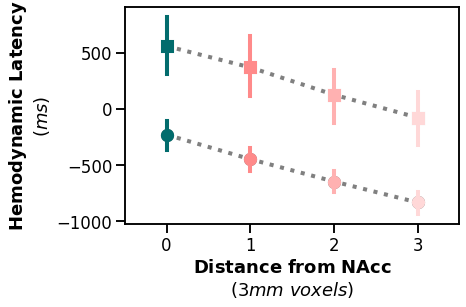

In [10]:
colors = ['#026C6D',
          '#FF8A8A', 
        '#FFB1B1',
        '#FFD8D8']

cocaine = shell_df[shell_df['group'] == 'cocaine']
control = shell_df[shell_df['group'] == 'control']

ax_supplement = sns.pointplot(x = 'distance',
             y = 'lag',
              color = 'grey',
             errorbar = None,
              linestyles=':',
            markers = 's',
             data = cocaine)

sns.pointplot(x = 'distance',
             y = 'lag',
             errorbar=('ci', 68),
              hue = 'distance',
              markers = 's',
              palette = colors,
            legend = False,
             data = cocaine,
             ax = ax_supplement)

ax_supplement = sns.pointplot(x = 'distance',
             y = 'lag',
              color = 'grey',
             errorbar = None,
              linestyles=':',
            markers = 'o',
             data = control)

sns.pointplot(x = 'distance',
             y = 'lag',
             errorbar=('ci', 68),
              hue = 'distance',
              markers = 'o',
              palette = colors,
            legend = False,
             data = control,
             ax = ax_supplement)

ax_supplement.set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '$\\bf{Distance\ from\ NAcc}$\n$\it{(3mm\ voxels)}$')
# plt.savefig('../figs/paper/figS2_figs.png',
#                             bbox_inches = 'tight',
#             dpi = 300)